# Seq2seq (Encoder+Decoder) LSTM

In [6]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING messages

In [9]:
import tensorflow as tf
import tensorflow as tf
tf.random.set_seed(0)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [10]:
TRAIN_RANGE = (datetime.datetime(2015, 5, 27), datetime.datetime(2018, 5, 22))
VALID_RANGE = (datetime.datetime(2018, 5, 23), datetime.datetime(2019, 5, 22))
TEST_RANGE = (datetime.datetime(2019, 5, 23), datetime.datetime(2020, 5, 22))
ENCODER_TIMESTEPS = 12  # Input 12 months to predict next month
DECODER_TIMESTEPS = 6  # Slide 6 months when decoder predicts

## 1. Read in dataset

In [11]:
data = pd.read_csv('/Users/priya/DL Projects/Timeseries Analysis/AAPL.csv')

In [12]:
import datetime

def str_to_datetime(s):
    # If already a datetime or date, return as-is
    if isinstance(s, (datetime.datetime, datetime.date)):
        return s
    
    # Otherwise, parse from string
    date_part = s.split(' ')[0]
    year, month, day = map(int, date_part.split('-'))
    return datetime.datetime(year=year, month=month, day=day)
data=data[['date','close']]
data.rename(columns={'close':'stock_price'},inplace=True)
data['date']=data['date'].apply(str_to_datetime)
data['date']
data.index = data.pop('date')  # Set datetime index
data.head()

,stock_price
date,
2015-05-27,132.045
2015-05-28,131.780
2015-05-29,130.280
2015-06-01,130.535
2015-06-02,129.960


<Axes: title={'center': 'Daily Apple Stock Price'}, xlabel='date'>

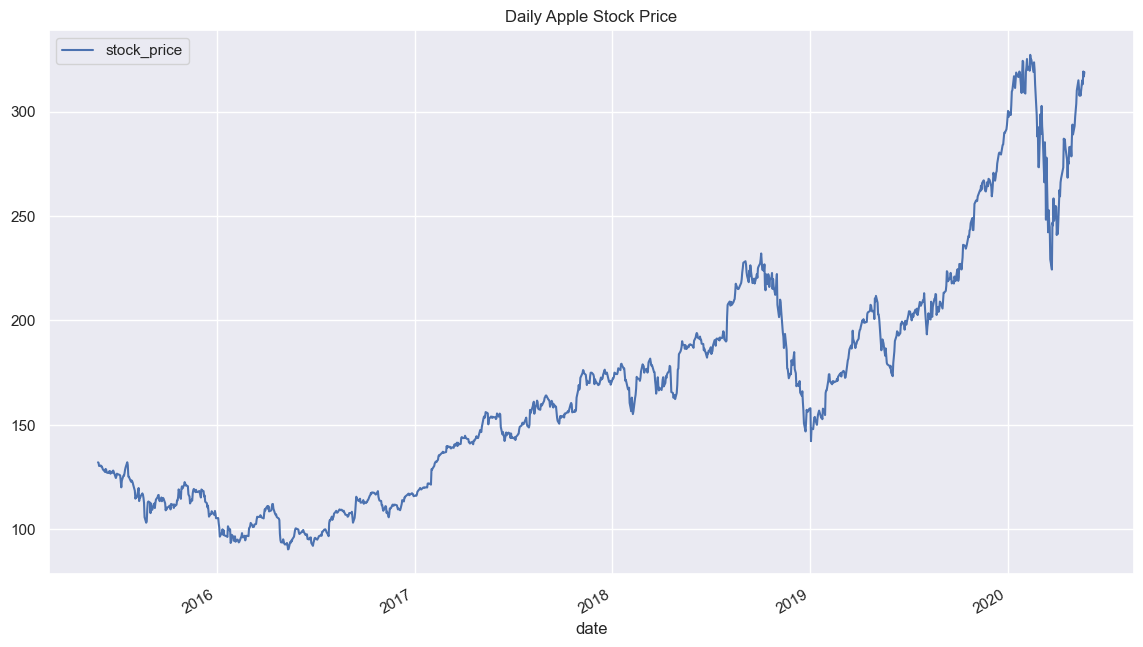

In [13]:
data.plot(figsize=(14, 8), title='Daily Apple Stock Price')

## 2.1 Normalize dataset

<Axes: title={'center': 'Daily normalized Apple Stock Price'}, xlabel='date'>

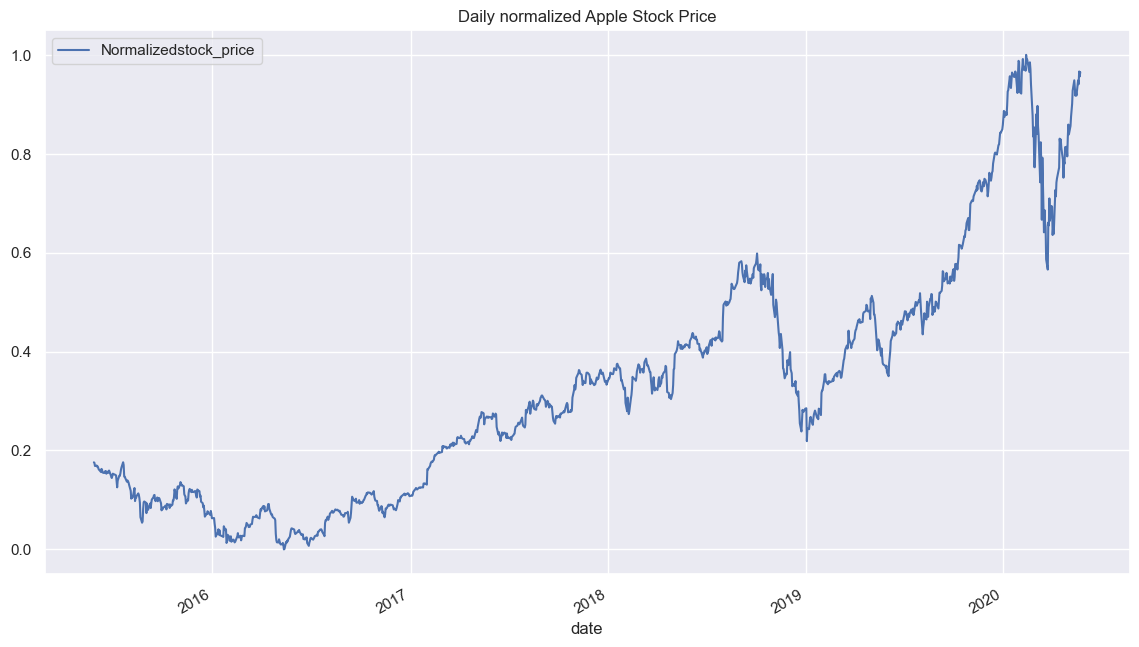

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['Normalizedstock_price'] = scaler.fit_transform(data['stock_price'].values.reshape(-1, 1)).flatten()
data[['Normalizedstock_price']].plot(figsize=(14, 8), title='Daily normalized Apple Stock Price')

## 2.2 Preprocess dataset

In [15]:
def create_dataset(data, enc_timesteps=ENCODER_TIMESTEPS, dec_timesteps=DECODER_TIMESTEPS):
    """Create input and output pairs for training lstm.
    Params:
        data (pandas.DataFrame): Normalized dataset
        enc_timesteps (int, default: ENCODER_TIMESTEPS): Input time length of encoder
        dec_timesteps (int, default: DECODER_TIMESTEPS): Input time length of decoder
    Returns:
        X_encoder (numpy.array): Input for encoder
        X_decoder (numpy.array): Input for decoder
        y (numpy.array): Output for decoder
        y_date (list): Datetime of output
        start_values (list): Start valeus of each input
    """
    X_encoder, X_decoder, y, y_date, start_values = [], [], [], [], []
    
    for i in range(len(data) - enc_timesteps - dec_timesteps):
        Xt_encoder = data.iloc[i:i+enc_timesteps].values
        Xt_decoder = data.iloc[i+enc_timesteps-dec_timesteps:i+enc_timesteps].values
        yt = data.iloc[i+enc_timesteps:i+enc_timesteps+dec_timesteps].values
        yt_date = data.index[i+enc_timesteps].to_pydatetime()  # Get start date of decoder output
        
        # Subtract a start value from each values in the timestep.
        start_value = Xt_encoder[0]
        Xt_encoder = Xt_encoder - start_value
        Xt_decoder = Xt_decoder - start_value
        yt = yt - start_value
        
        X_encoder.append(Xt_encoder)
        X_decoder.append(Xt_decoder)
        y.append(yt)
        y_date.append(yt_date)
        start_values.append(start_value)
        
    return np.array(X_encoder), np.array(X_decoder), np.array(y), y_date, start_values

In [16]:
def split_train_valid_test(X_encoder, X_decoder, y, y_date, train_range=TRAIN_RANGE, valid_range=VALID_RANGE, test_range=TEST_RANGE):
    """Split X and y into train, valid, and test periods.
    Params:
        X_encoder (numpy.array): Input for encoder
        X_decoder (numpy.array): Input for decoder
        y (numpy.array): Output for lstm
        y_date (list): Datetime of output
        train_range (tuple): Train period
        valid_range (tuple): Validation period
        test_range (tuple): Test period
    Returns:
        X_encoder_train (pandas.DataFrame), X_decoder_train (pandas.DataFrame)
        X_encoder_valid (pandas.DataFrame), X_decoder_valid (pandas.DataFrame)
        X_encoder_test (pandas.DataFrame), X_decoder_test (pandas.DataFrame)
        y_train (pandas.DataFrame)
        y_valid (pandas.DataFrame)
        y_test (pandas.DataFrame)
        y_date_train (list)
        y_date_valid (list)
        y_date_test (list)
    """
    train_end_idx = y_date.index(train_range[1])
    valid_end_idx = y_date.index(valid_range[1])
    
    X_encoder_train = X_encoder[:train_end_idx+1, :]
    X_encoder_valid = X_encoder[train_end_idx+1:valid_end_idx+1, :]
    X_encoder_test = X_encoder[valid_end_idx+1:, :]
    
    X_decoder_train = X_decoder[:train_end_idx+1, :]
    X_decoder_valid = X_decoder[train_end_idx+1:valid_end_idx+1, :]
    X_decoder_test = X_decoder[valid_end_idx+1:, :]
    
    y_train = y[:train_end_idx+1]
    y_valid = y[train_end_idx+1:valid_end_idx+1]
    y_test = y[valid_end_idx+1:]
    
    y_date_train = y_date[:train_end_idx+1]
    y_date_valid = y_date[train_end_idx+1:valid_end_idx+1]
    y_date_test = y_date[valid_end_idx+1:]
    
    return X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, X_encoder_test, X_decoder_test, \
                y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test

In [17]:
# Create input and output pairs for training lstm.
X_encoder, X_decoder, y, y_date, start_values = create_dataset(data[['Normalizedstock_price']])

# Split X and y into train, valid, and test periods.
X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, X_encoder_test, X_decoder_test, \
    y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test = split_train_valid_test(X_encoder, X_decoder, y, y_date)

In [18]:
print(X_encoder_train.shape, X_encoder_valid.shape, X_encoder_test.shape)
print(X_decoder_train.shape, X_decoder_valid.shape, X_decoder_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(742, 12, 1) (251, 12, 1) (247, 12, 1)
(742, 6, 1) (251, 6, 1) (247, 6, 1)
(742, 6, 1) (251, 6, 1) (247, 6, 1)


## 3. Create seq2seq (Encoder+Decoder) LSTM model

In [19]:
def create_model(enc_timesteps=ENCODER_TIMESTEPS, dec_timesteps=DECODER_TIMESTEPS):
    # Create encoder
    encoder_inputs = Input(shape=(enc_timesteps, 1), name='encoder_input')
    encoder, state_h1, state_c1 = LSTM(128, return_sequences=True, return_state=True, name='encoder_lstm_1')(encoder_inputs)
    encoder_states1 = [state_h1, state_c1]
    
    encoder_outputs, state_h2, state_c2 = LSTM(32, return_state=True, name='encoder_lstm_2')(encoder)
    encoder_states2 = [state_h2, state_c2]

    # Create decoder
    decoder_inputs = Input(shape=(dec_timesteps, 1), name='decoder_input')    
    decoder, _, _ = LSTM(128, return_sequences=True, return_state=True, name='decoder_lstm_1')(decoder_inputs, initial_state=encoder_states1)
    decoder, _, _ = LSTM(32, return_sequences=True, return_state=True, name='decoder_lstm_2')(decoder, initial_state=encoder_states2)

    
    # Create output layer
    decoder_outputs = Dense(1)(decoder)
    
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=0.01), metrics=['mean_absolute_error'])
    return model

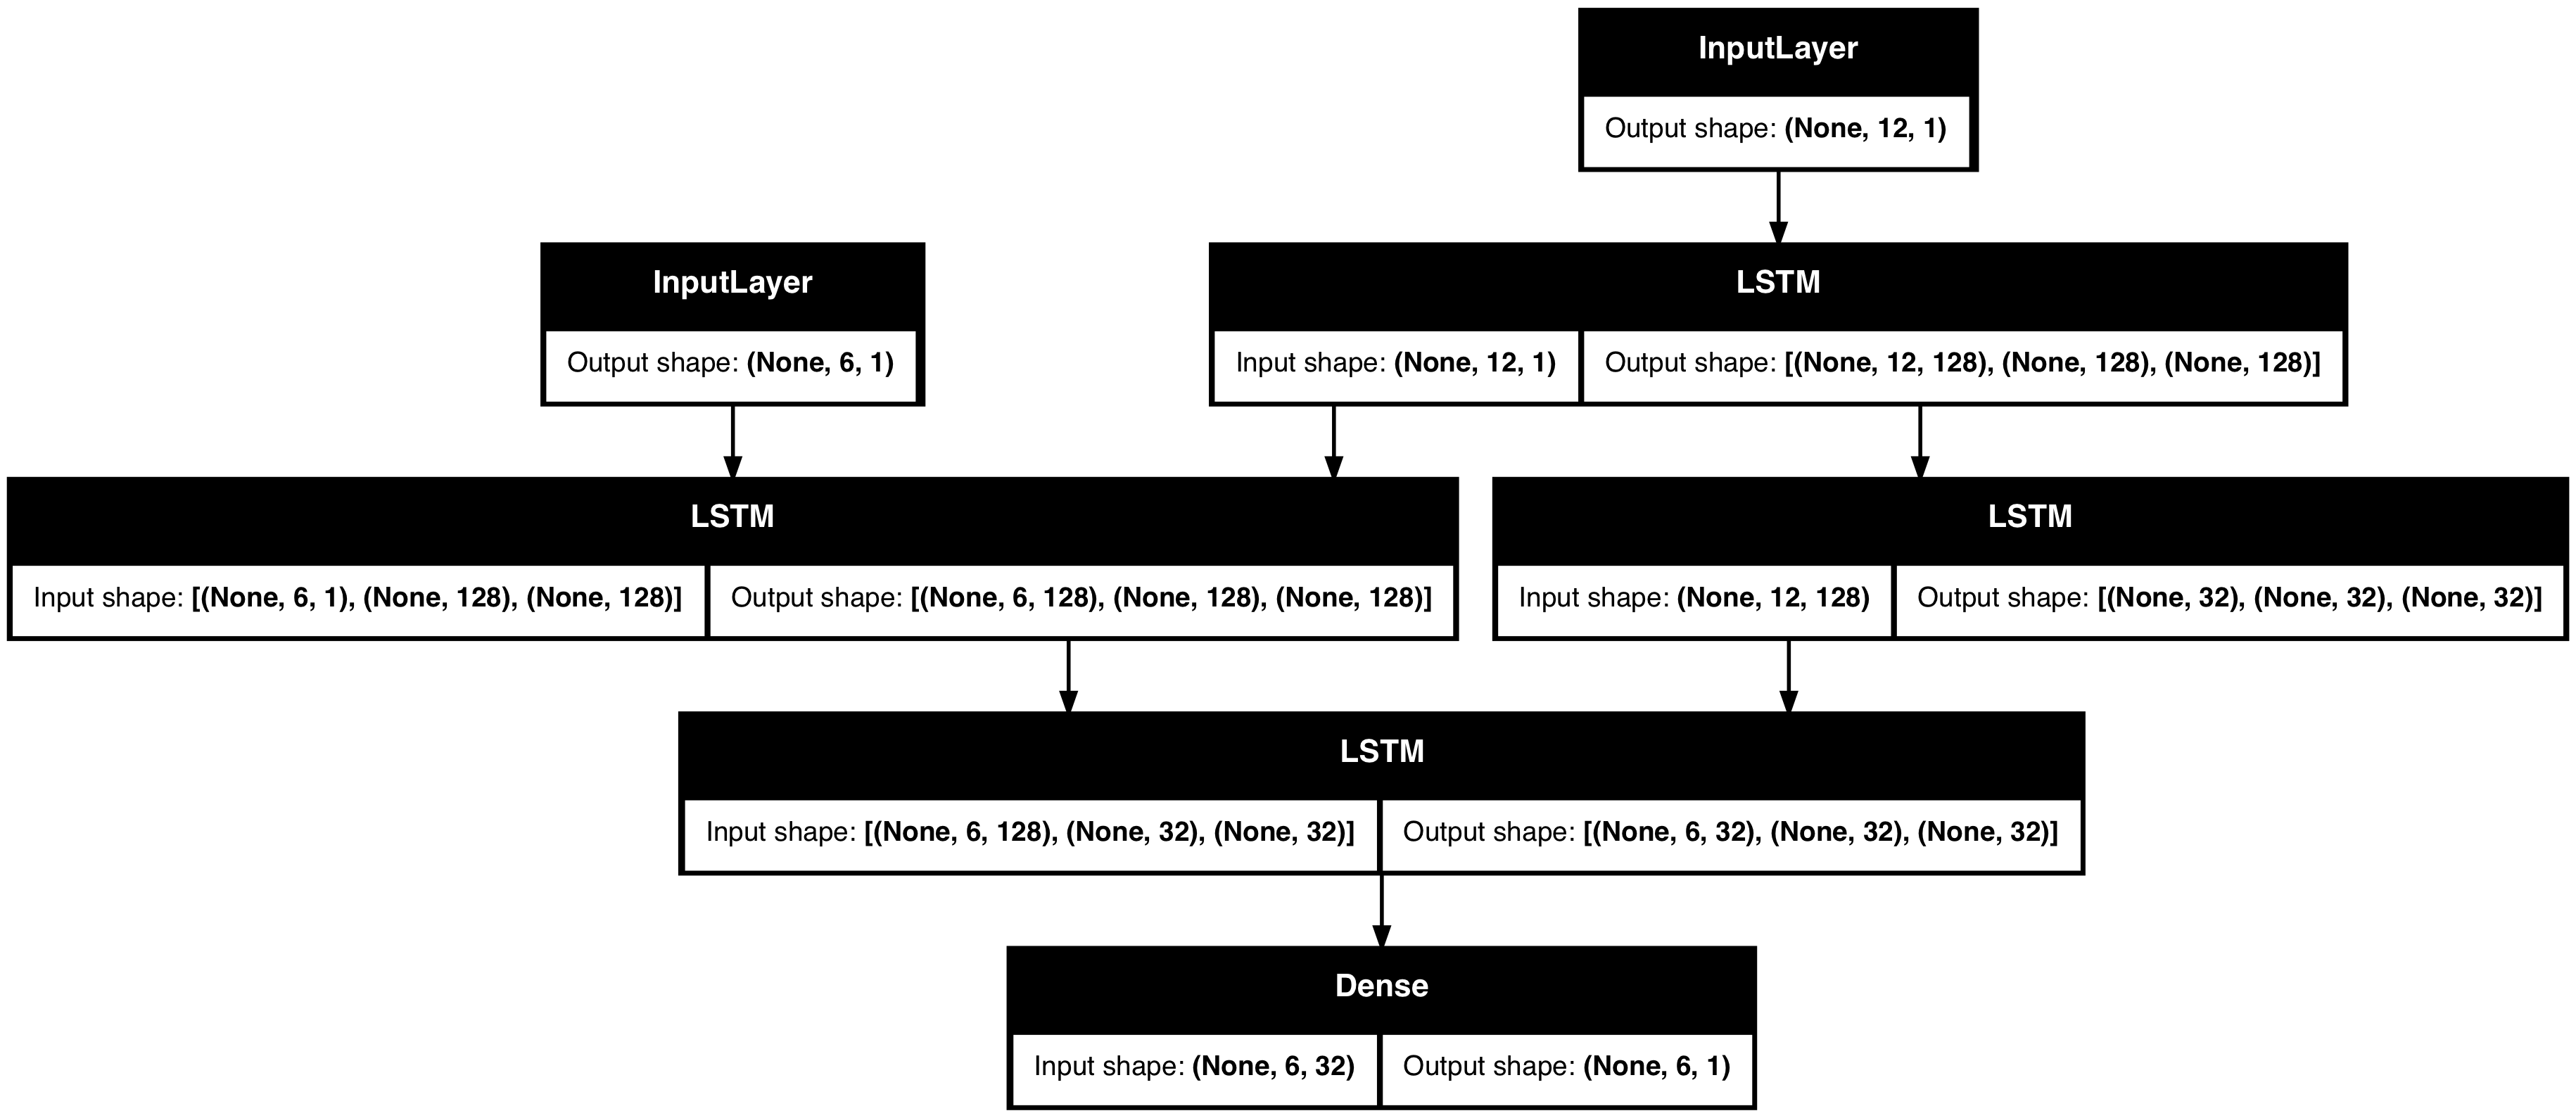

In [20]:
# Create model
model = create_model()
plot_model(model, show_shapes=True)

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm_1      │ [(None, 12, 128), │     66,560 │ encoder_input[0]… │
│ (LSTM)              │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_1      │ [(None, 6, 128),  │     66,560 │ decoder_input[0]… │
│ (LSTM)              │ (None, 128),      │            │ encoder_lstm_1[0… │
│                     │ (None, 128)]      │            │ encoder_lstm_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm_2      │ [(None, 32),      │     20,608 │ encoder_lstm_1[0… │
│ (LSTM)              │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_2      │ [(None, 6, 32),   │     20,608 │ decoder_lstm_1[0… │
│ (LSTM)              │ (None, 32),       │            │ encoder_lstm_2[0… │
│                     │ (None, 32)]       │            │ encoder_lstm_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6, 1)      │         33 │ decoder_lstm_2[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 174,369 (681.13 KB)

 Trainable params: 174,369 (681.13 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Callbacks of training.
es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, patience=15, verbose=1, mode='auto')
fn = 'trained_model.keras'
mc = ModelCheckpoint(filepath=fn, save_best_only=True)
callbacks = [es, mc]

In [23]:
# Start training model.
fit = model.fit(
    [X_encoder_train, X_decoder_train], y_train, 
    batch_size=32,
    epochs=1000, 
    verbose=2,
    validation_data=([X_encoder_valid, X_decoder_valid], y_valid), 
    callbacks=callbacks)

Epoch 1/1000
24/24 - 10s - 408ms/step - loss: 0.0020 - mean_absolute_error: 0.0306 - val_loss: 0.0016 - val_mean_absolute_error: 0.0299
Epoch 2/1000
24/24 - 1s - 24ms/step - loss: 4.8571e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0011 - val_mean_absolute_error: 0.0245
Epoch 3/1000
24/24 - 1s - 24ms/step - loss: 5.1920e-04 - mean_absolute_error: 0.0175 - val_loss: 9.5984e-04 - val_mean_absolute_error: 0.0239
Epoch 4/1000
24/24 - 1s - 25ms/step - loss: 3.8480e-04 - mean_absolute_error: 0.0145 - val_loss: 7.3747e-04 - val_mean_absolute_error: 0.0206
Epoch 5/1000
24/24 - 1s - 25ms/step - loss: 3.6189e-04 - mean_absolute_error: 0.0139 - val_loss: 6.8749e-04 - val_mean_absolute_error: 0.0201
Epoch 6/1000
24/24 - 1s - 21ms/step - loss: 3.7370e-04 - mean_absolute_error: 0.0143 - val_loss: 6.8988e-04 - val_mean_absolute_error: 0.0202
Epoch 7/1000
24/24 - 1s - 21ms/step - loss: 3.3475e-04 - mean_absolute_error: 0.0134 - val_loss: 6.8916e-04 - val_mean_absolute_error: 0.0199
Epoch 8/1000
24/

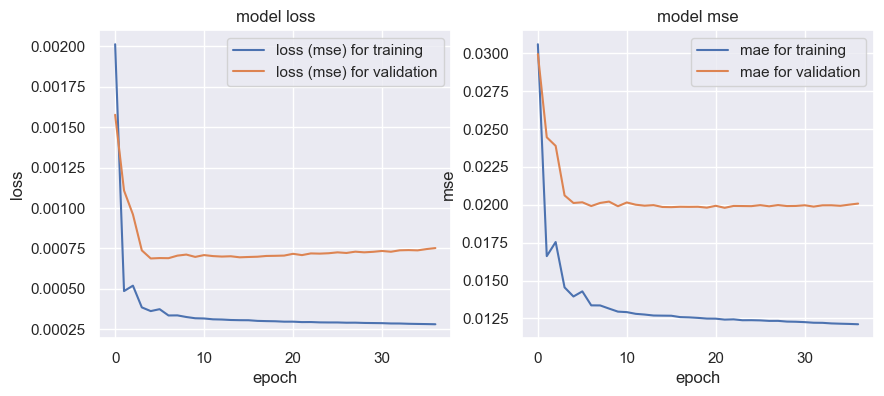

In [24]:
# Plot training history
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10, 4))
axL.plot(fit.history['loss'], label="loss (mse) for training")
axL.plot(fit.history['val_loss'], label="loss (mse) for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')

axR.plot(fit.history['mean_absolute_error'], label="mae for training")
axR.plot(fit.history['val_mean_absolute_error'], label="mae for validation")
axR.set_title('model mse')
axR.set_xlabel('epoch')
axR.set_ylabel('mse')
axR.legend(loc='upper right')

plt.show()

# Load best model
model = load_model(fn)

In [25]:
def evaluate_model(data, scaler, X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, \
                   X_encoder_test, X_decoder_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model, \
                  pred_timesteps=0):
    """Evaluate trained model by rmse (root mean squared error) and mae (mean absolute error)'
    Params:
        pred_timesteps (int): (t + T + pred_timesteps)th month if predicted from t ~ t + T months
    """
    
    # Predict next month passengers
    pred_train = model.predict([X_encoder_train, X_decoder_train])[:, pred_timesteps]
    pred_valid = model.predict([X_encoder_valid, X_decoder_valid])[:, pred_timesteps]
    pred_test = model.predict([X_encoder_test, X_decoder_test])[:, pred_timesteps]
    
    # Add start_values that were subtracted when preprocessing.
    pred_train  = pred_train + start_values[:len(X_encoder_train)]
    pred_valid  = pred_valid + start_values[len(X_encoder_train):len(X_encoder_train)+len(X_encoder_valid)]
    pred_test  = pred_test + start_values[len(X_encoder_train)+len(X_encoder_valid):]
    
    # Inverse transform normalization
    pred_train = scaler.inverse_transform(pred_train).flatten()
    pred_valid = scaler.inverse_transform(pred_valid).flatten()
    pred_test = scaler.inverse_transform(pred_test).flatten()
    
    # Plot prediction result
    pred_df = pd.DataFrame({
        'Stock_price': data['stock_price'].values,
        'PredictionTrain': np.nan, 'PredictionValid': np.nan, 'PredictionTest': np.nan
    })
    
    train_start_idx = ENCODER_TIMESTEPS + pred_timesteps
    valid_start_idx = train_start_idx + len(pred_train)
    test_start_idx = valid_start_idx + len(pred_valid)
    
    pred_df.loc[train_start_idx:valid_start_idx - 1, 'PredictionTrain'] = pred_train
    pred_df.loc[valid_start_idx:test_start_idx-1, 'PredictionValid'] = pred_valid
    pred_df.loc[test_start_idx:test_start_idx+ len(pred_test)-1, 'PredictionTest'] = pred_test
    
    pred_df.idx =  data.index
    pred_df[['Stock_price', 'PredictionTrain', 'PredictionValid', 'PredictionTest']].plot(figsize=(12, 6), title='Predicted Daily Apple Stock Price')
    
    # Add start_values that were subtracted when preprocessing.
    y_train  = y_train[:, pred_timesteps] + start_values[:len(X_encoder_train)]
    y_valid  = y_valid[:, pred_timesteps] + start_values[len(X_encoder_train):len(X_encoder_train)+len(X_encoder_valid)]
    y_test  = y_test[:, pred_timesteps] + start_values[len(X_encoder_train)+len(X_encoder_valid):]
    
    # Inverse transform normalization
    y_train = scaler.inverse_transform(y_train).flatten()
    y_valid = scaler.inverse_transform(y_valid).flatten()
    y_test = scaler.inverse_transform(y_test).flatten()
    
    # Evaluate prediction scores of model.
    for y, pred, mode in zip([y_train, y_valid, y_test], [pred_train, pred_valid, pred_test], ['train', 'valid', 'test']):
        rmse = np.sqrt(mean_squared_error(y, pred))
        mae = mean_absolute_error(y, pred)
        print(f'{mode} rmse: {rmse:.06f}, mae: {mae:.06f}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
train rmse: 2.556169, mae: 1.832134
valid rmse: 4.148454, mae: 3.219033
test rmse: 7.027301, mae: 4.655404


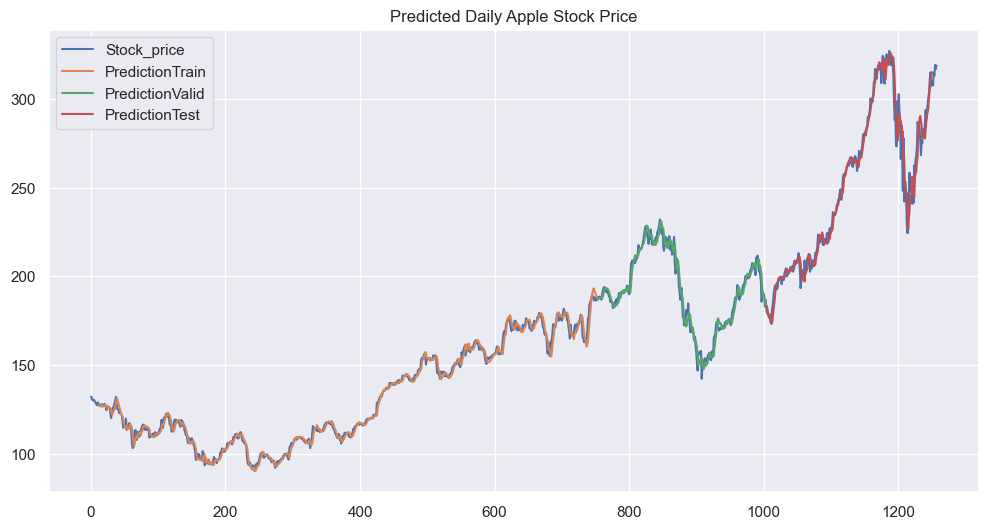

In [26]:
# Predict next month.
evaluate_model(data, scaler, X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, \
               X_encoder_test, X_decoder_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model, \
              pred_timesteps=0)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
train rmse: 5.567194, mae: 4.139882
valid rmse: 7.693540, mae: 5.990700
test rmse: 12.977568, mae: 9.221494


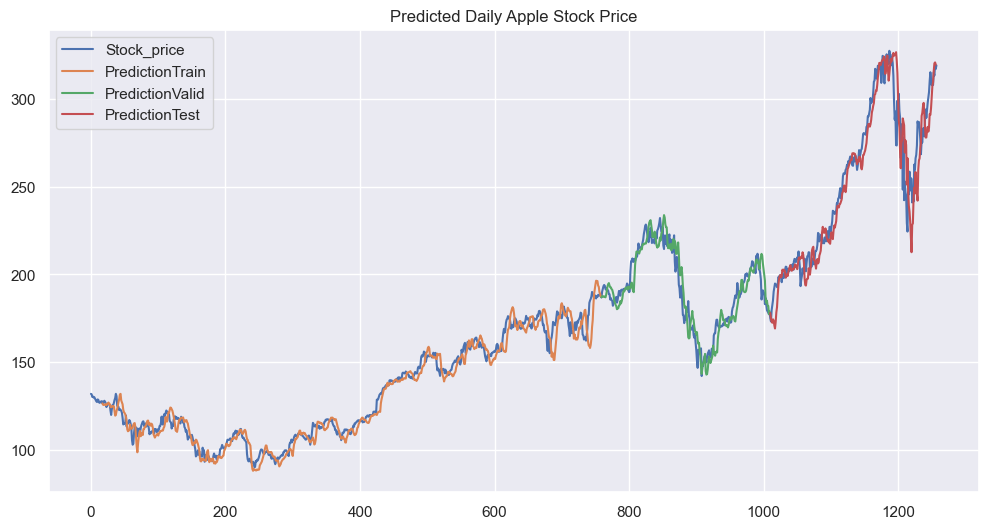

In [27]:
# Predict next 5 months
evaluate_model(data, scaler, X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, \
               X_encoder_test, X_decoder_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model, \
              pred_timesteps=DECODER_TIMESTEPS-1)